# Data Exploration
Skyeler McQueen

skyelerm@umich.edu

In this file, I explore and clean the *Star Trek: The Next Generation* data that I scraped and generate the baselines.

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.metrics
import torch
torch.manual_seed(42)
np.random.seed(42)

Setting the color palette.

In [13]:
palette = ['#F84AA7','#03256C','#F3CA40','#FF3562','#F2A541']
sns.set_palette(palette)

Reading & manipulating data

In [14]:
# read in data
data = pd.read_csv('scripts_tng/complete_data.csv')

# strip character name
data['character']=data['character'].apply(lambda x: str(x).strip())

In [15]:
# get the top 10 most frequent characters
top_10 = data['character'].value_counts().head(10).reset_index()
t_10_list = list(top_10['character'])

# if not in top 10, then give label 'OTHER'
data['character'] = data['character'].apply(lambda x: x if x in t_10_list else 'OTHER') # will need to do this in the dataset

In [16]:
# save this data as the mc_data.csv
data.to_csv('mc_data.csv')

Now we will calculate some statistics on this data.

In [17]:
percentages = data['character'].value_counts().reset_index()
total = sum(percentages['count'])

percentages['percent']=percentages['count'].apply(lambda x: x/total)


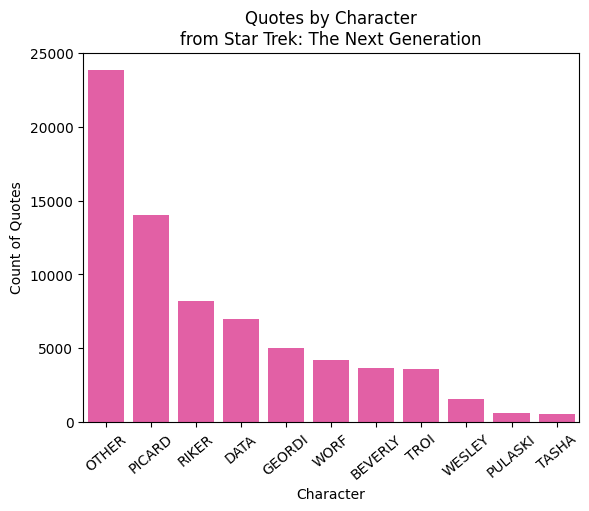

In [18]:
sns.barplot(data=data['character'].value_counts().reset_index(),x='character',y='count',color="#F84AA7")
plt.xlabel('Character')
plt.ylabel('Count of Quotes')
plt.title('Quotes by Character\nfrom Star Trek: The Next Generation')
_=plt.xticks(rotation=40)

In [19]:
data.groupby('episode').nunique()['character'].sort_values(ascending=False)

episode
"Shades of Gray"                 11
"Where None Have Gone Before"    10
"Home Soil"                      10
"Encounter at Farpoint"          10
"Justice"                        10
                                 ..
"Cost of Living"                  7
"Identity Crisis"                 7
"First Contact"                   7
"Captain's Holiday"               6
"Redemption"                      5
Name: character, Length: 176, dtype: int64

In [20]:
data['episode'].value_counts()

episode
"All Good Things... "      895
"Encounter at Farpoint"    730
"Shades of Gray"           552
"Samaritan Snare"          539
"Lower Decks"              491
                          ... 
"Schisms"                  323
Hide And "Q"               314
"The Royale"               313
"A Fistful of Datas"       311
"Birthright"               309
Name: count, Length: 176, dtype: int64

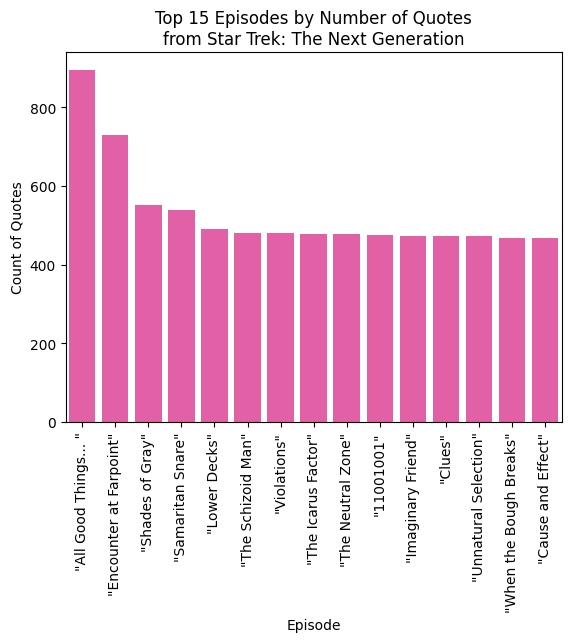

In [21]:
sns.barplot(data=data['episode'].value_counts().head(15).reset_index(),x='episode',y='count',color="#F84AA7")
plt.xlabel('Episode')
plt.ylabel('Count of Quotes')
plt.title('Top 15 Episodes by Number of Quotes\nfrom Star Trek: The Next Generation')
_=plt.xticks(rotation=90)

Here I will begin getting the data prepared for sentence transformers to calculate sentence similarity.

In [22]:
sbert_data = data.copy()
sbert_data = sbert_data[sbert_data.character.isin(t_10_list)] # only want to use the top 10 list, not the others
shuffled_sbert_data = sbert_data.sample(frac=1,random_state=3).reset_index().rename({'index':'index_y'},axis=1)
sbert_data_final = pd.merge(sbert_data.reset_index(),shuffled_sbert_data.reset_index(),on='index') #need to run full thing on pc

In [23]:
sbert_data_final=sbert_data_final.rename({'index':'index_x'},axis=1)

In [24]:
sbert_data_final=sbert_data_final[['index_x','index_y','quote_x','quote_y','character_x','character_y']]
sbert_data_final

,index_x,index_y,quote_x,quote_y,character_x,character_y
0,0,19361,"Captain's log, stardate 42353.7. Our destina...",Amanda... is a Q... ?,PICARD,TROI
1,1,14723,"My orders are to examine Farpoint, a star...",I think... we're putting on a drumhead tr...,PICARD,PICARD
2,2,9401,... I am becoming better acquainted w...,"Captain's log, Stardate 42686.9.",PICARD,PICARD
3,3,55359,I am still somewhat in awe of its size an...,"Mister La Forge, my reputation as a litig...",PICARD,PICARD
4,4,42041,... my crew we are short in several k...,What happened? Did he eat anything? Did h...,PICARD,PULASKI
...,...,...,...,...,...,...
32619,48480,37279,It might be Morag... there's no way t...,And the famous Holmes violin. He purchase...,RIKER,DATA
32620,48481,71830,Right...,It might.,GEORDI,GEORDI
32621,48482,16985,Get some rest. This has been a tough coup...,It was a very long time ago.,RIKER,PICARD
32622,48483,2368,Thanks...,We have completed our survey on the s...,GEORDI,PICARD


In [25]:
def similarity(row:pd.Series):
    '''This function calculates whether or not the random pair of quotes are spoken by the same person.
    '''
    sim = 0
    if row['character_x']==row['character_y']:
        sim=1
    return sim

sbert_data_final['similarity']=sbert_data_final.apply(similarity,axis=1)

In [26]:
sbert_data_final.to_csv('sbertdata.csv')

In [27]:
sbert_data_final.sample(5)

,index_x,index_y,quote_x,quote_y,character_x,character_y,similarity
26857,39236,64790,Yes... ?,I believe Serova is attempting to cre...,PICARD,DATA,0
14161,21277,32811,"Any idea what the message was, Data?",I've restored attitude control to the...,GEORDI,PICARD,0
30107,44546,30078,What happened to him?,"Captain, the Enterprise... C is sending o...",RIKER,TASHA,0
9976,14453,44064,"May I say goodbye to Doctor Soong, sir?","There they are, sir.",DATA,RIKER,0
23748,34666,30976,"Sit down, Captain.","How far beyond, sir?",BEVERLY,DATA,0


In [28]:
sbert_percentages = sbert_data_final['similarity'].value_counts().reset_index()
sbert_total = sbert_percentages['count'].sum()
sbert_percentages['percent']=sbert_percentages['count'].apply(lambda x: x/sbert_total)

In [29]:
sbert_percentages

,similarity,count,percent
0,0,27450,0.841405
1,1,5174,0.158595


# Calculate Baselines

I will start by randomly assigning a 0 or 1 to each item in the sbert data.

In [34]:
sbert_prob_dist = [float(sbert_percentages[sbert_percentages.similarity == x].percent.iloc[0]) for x in [0,1]]
np.random.seed(55)
def get_sbert_baseline(row:pd.Series):
    return np.random.choice(np.arange(0, 2), p=sbert_prob_dist)
sbert_data_final['baseline'] = sbert_data_final.apply(get_sbert_baseline,axis=1)

In [35]:
sbert_data_final

,index_x,index_y,quote_x,quote_y,character_x,character_y,similarity,baseline
0,0,19361,"Captain's log, stardate 42353.7. Our destina...",Amanda... is a Q... ?,PICARD,TROI,0,0
1,1,14723,"My orders are to examine Farpoint, a star...",I think... we're putting on a drumhead tr...,PICARD,PICARD,1,1
2,2,9401,... I am becoming better acquainted w...,"Captain's log, Stardate 42686.9.",PICARD,PICARD,1,0
3,3,55359,I am still somewhat in awe of its size an...,"Mister La Forge, my reputation as a litig...",PICARD,PICARD,1,0
4,4,42041,... my crew we are short in several k...,What happened? Did he eat anything? Did h...,PICARD,PULASKI,0,0
...,...,...,...,...,...,...,...,...
32619,48480,37279,It might be Morag... there's no way t...,And the famous Holmes violin. He purchase...,RIKER,DATA,0,0
32620,48481,71830,Right...,It might.,GEORDI,GEORDI,1,0
32621,48482,16985,Get some rest. This has been a tough coup...,It was a very long time ago.,RIKER,PICARD,0,0
32622,48483,2368,Thanks...,We have completed our survey on the s...,GEORDI,PICARD,0,0


In [32]:
f1_scores_sbert = sklearn.metrics.f1_score(sbert_data_final['similarity'],sbert_data_final['baseline'],average='binary')
f1_scores_sbert

0.15236427320490367

Above is our baseline F1 score for the sentence similarity data.

Now we will calculate the baseline for the multi label classifier.

In [33]:
# generate ids for each label
label_to_id = {}
id_to_label = {}
all_labels = t_10_list+['OTHER']
for x in range(len(all_labels)):
    label_to_id[all_labels[x]]=x
    id_to_label[x]=all_labels[x]

In [36]:
# create probability distribution based on frequency of each character
prob_dist = [float(percentages[percentages.character == x].percent.iloc[0]) for x in all_labels]
all_ids = [label_to_id[y] for y in all_labels]

In [38]:
# set seed
np.random.seed(55)

In [39]:
def get_mc_baseline(row:pd.Series):
    '''Returns a random number corresponding to the id labels.'''
    return np.random.choice(np.arange(0, 11), p=prob_dist)

In [40]:
data['mc_baseline'] = data.apply(get_mc_baseline,axis=1)
data['id'] = data.character.apply(lambda x: label_to_id[x])

Get the F1 scores per each label and overall.

In [43]:
all_labels

['PICARD',
 'RIKER',
 'DATA',
 'GEORDI',
 'WORF',
 'BEVERLY',
 'TROI',
 'WESLEY',
 'PULASKI',
 'TASHA',
 'OTHER']

In [41]:
f1_scores_per_class = sklearn.metrics.f1_score(data['id'],data['mc_baseline'],labels=all_ids,average=None)
f1_scores_per_class

array([0.19975004, 0.11472415, 0.1007808 , 0.06938695, 0.06084561,
       0.05312158, 0.05440486, 0.02349206, 0.00615858, 0.01382887,
       0.3326209 ])

In [42]:
weighted_f1 = sklearn.metrics.f1_score(data['id'],data['mc_baseline'],labels=all_ids,average='weighted')
weighted_f1

0.18551409421239132